In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm

import yfinance as yf

In [6]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1222, 6)


In [7]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.876099,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.167603,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.742645,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.400551,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.565193,75.797501,76.110001,74.290001,74.290001,132079200


### PCA weights from a risk distribution R

In [8]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [9]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [10]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i].values[0]), min(0, sNeg + diff.loc[i].values[0])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [11]:
prices = data['Close']
events = getTEvents(prices, 5)

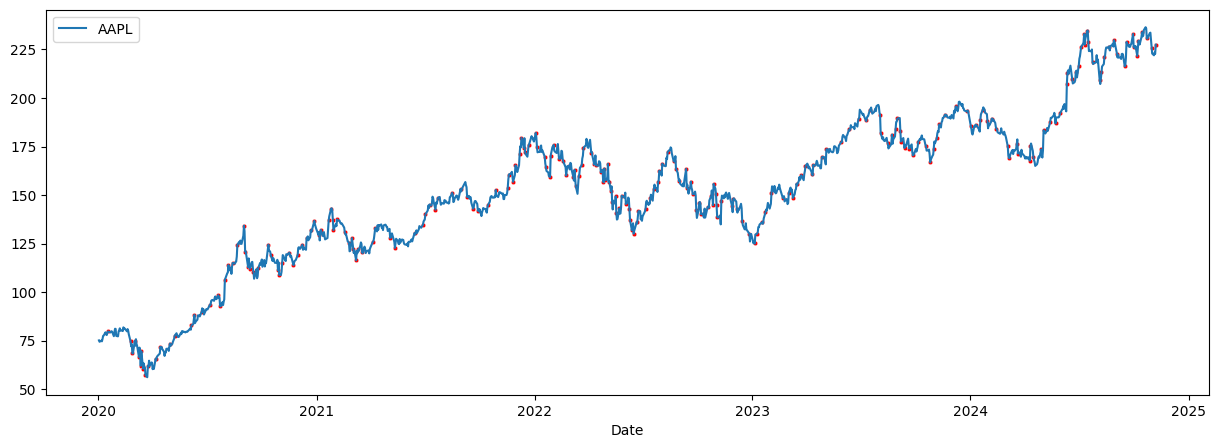

In [12]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

## Exercise

In [146]:
## get the data
es_data = yf.download("ES=F", start='2022-11-11', interval="1h") 
print(es_data.shape)

[*********************100%***********************]  1 of 1 completed

(11395, 6)


In [147]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F,ES=F
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3984.5,3984.5,3985.25,3966.00,3969.25,0
2022-11-11 06:00:00+00:00,3988.5,3988.5,3990.75,3981.50,3984.50,17131
2022-11-11 07:00:00+00:00,3994.0,3994.0,3995.00,3981.75,3988.50,19194
2022-11-11 08:00:00+00:00,3995.5,3995.5,3997.50,3981.00,3994.00,34204
2022-11-11 09:00:00+00:00,3984.0,3984.0,3995.75,3979.25,3995.75,31928


In [148]:
es_data.columns = es_data.columns.get_level_values(0)

In [149]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3984.5,3984.5,3985.25,3966.00,3969.25,0
2022-11-11 06:00:00+00:00,3988.5,3988.5,3990.75,3981.50,3984.50,17131
2022-11-11 07:00:00+00:00,3994.0,3994.0,3995.00,3981.75,3988.50,19194
2022-11-11 08:00:00+00:00,3995.5,3995.5,3997.50,3981.00,3994.00,34204
2022-11-11 09:00:00+00:00,3984.0,3984.0,3995.75,3979.25,3995.75,31928


In [205]:
def advanced_bars(series, h, bar_type = 'Volume'):
    index_name = es_data.index.name
    df = pd.DataFrame()
    temp_data = series.reset_index()
    current_vol = 0
    for i in range(len(temp_data)):
        if current_vol == 0:
                date, cum_high,cum_low,cum_open,cum_close,cum_adj_close = temp_data.iloc[i][index_name],temp_data.iloc[i]['High'],temp_data.iloc[i]['Low'],temp_data.iloc[i]['Open'],temp_data.iloc[i]['Close'],temp_data.iloc[i]['Adj Close']
        cum_high, cum_low = max(cum_high, temp_data.iloc[i]['High']), min(cum_low, temp_data.iloc[i]['Low'])
        if bar_type == 'Volume':
            current_vol += temp_data.iloc[i]['Volume']
        elif bar_type == 'Dollar':
            current_vol += temp_data.iloc[i]['Volume'] * temp_data.iloc[i]['Close']
        elif bar_type == 'Tick':
            current_vol += 1
        else:
            raise ValueError("bar_type Wrong! Please enter correct bar_type: Volume, Dollar or Tick")

        if (current_vol >= h):
            cum_close = temp_data.iloc[i][ 'Close']
            cum_adj_close = temp_data.iloc[i]['Adj Close']
            temp = pd.DataFrame([[date, cum_adj_close, cum_close, cum_high, cum_low, cum_open, current_vol]], columns = [index_name,'Adj Close','Close','High','Low','Open','Cum '+bar_type])
            current_vol = 0
            df = pd.concat([df, temp], axis=0)
    df.set_index(index_name, inplace=True)
    return df

In [206]:
tick_bars = advanced_bars(es_data, h=2, bar_type='Tick')
tick_bars.shape

(5697, 6)

In [208]:
volume_bars = advanced_bars(es_data, h=20000, bar_type='Volume')
volume_bars.shape

(6797, 6)

In [209]:
dollar_bars = advanced_bars(es_data, h=20000*5000, bar_type='Dollar')
dollar_bars.shape

(6683, 6)

In [210]:
tick_bars

,Adj Close,Close,High,Low,Open,Cum Tick
Datetime,,,,,,
2022-11-11 05:00:00+00:00,3988.50,3988.50,3990.75,3966.00,3969.25,2
2022-11-11 07:00:00+00:00,3995.50,3995.50,3997.50,3981.00,3988.50,2
2022-11-11 09:00:00+00:00,3976.50,3976.50,3995.75,3974.75,3995.75,2
2022-11-11 11:00:00+00:00,3980.75,3980.75,3983.25,3972.75,3976.75,2
2022-11-11 13:00:00+00:00,3967.25,3967.25,3984.50,3951.00,3981.00,2
...,...,...,...,...,...,...
2024-11-07 14:00:00+00:00,5994.50,5994.50,5996.25,5971.00,5973.25,2
2024-11-07 16:00:00+00:00,6000.50,6000.50,6002.00,5987.25,5994.50,2
2024-11-07 18:00:00+00:00,6006.75,6006.75,6006.75,5985.50,6000.50,2


In [213]:
tick_counts = tick_bars.resample('W-MON')['Close'].count()
dollar_counts = dollar_bars.resample('W-MON')['Close'].count()
volume_counts = volume_bars.resample('W-MON')['Close'].count()

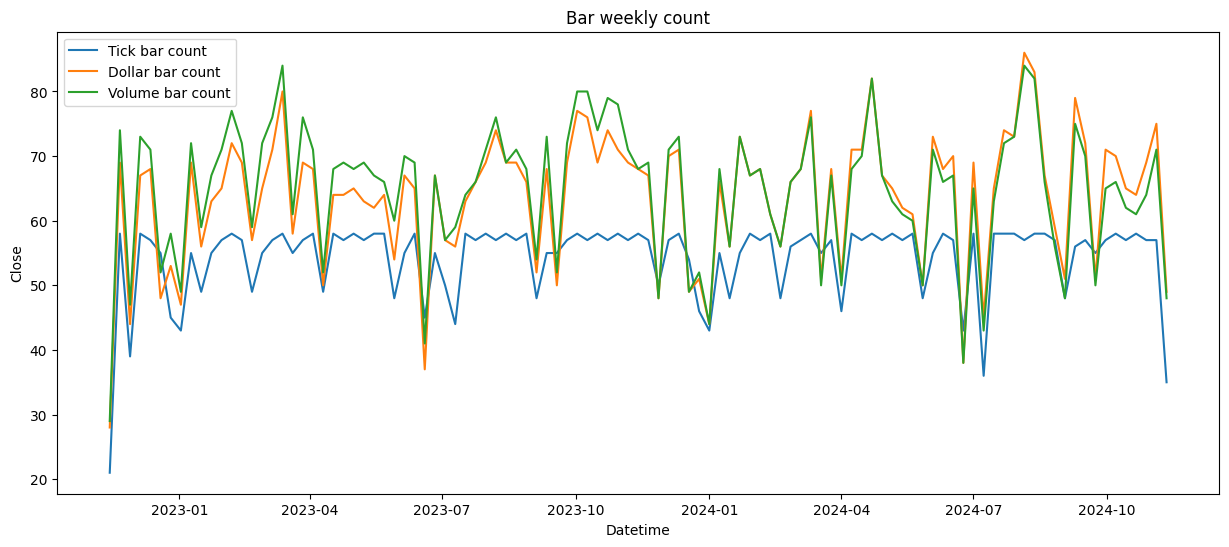

In [214]:
plt.figure(figsize=(15, 6))
sns.lineplot(tick_counts, label='Tick bar count')
sns.lineplot(dollar_counts, label = 'Dollar bar count')
sns.lineplot(volume_counts, label = 'Volume bar count')
plt.title("Bar weekly count")
plt.show()

In [215]:
count_df = pd.DataFrame(columns = ['count_mean', 'count_std'], index=['tick', 'volume', 'dollar'])
count_df.loc['tick'] = [tick_counts.mean(), tick_counts.std()]
count_df.loc['volume'] = [volume_counts.mean(), volume_counts.std()]
count_df.loc['dollar'] = [dollar_counts.mean(), dollar_counts.std()]
count_df

,count_mean,count_std
tick,54.257143,6.139451
volume,64.733333,10.593237
dollar,63.647619,10.36913


In [216]:
def returns(s):
    arr = np.diff(np.log(s))
    return pd.Series(arr, index=s.index[1:])

In [218]:
tick_returns = returns(tick_bars['Close'])
volume_returns = returns(volume_bars['Close'])
dollar_returns = returns(dollar_bars['Close'])
pd.DataFrame([tick_returns.autocorr(), volume_returns.autocorr(), dollar_returns.autocorr()], columns=['returns_corr'], index=['tick', 'volume', 'dollar'])

,returns_corr
tick,-0.001384
volume,0.026892
dollar,0.029672


In [221]:
def partition_monthly(s):
    return s.resample("1ME").var()

In [224]:
tick_monthly = partition_monthly(tick_returns)
volume_monthly = partition_monthly(volume_returns)
dollar_monthly = partition_monthly(dollar_returns)